In [1]:
import sys
import cv2
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
import caffe
import glob
from matplotlib import pyplot as plt
import json 
from cmc import cmc
import os
from random import randint
%matplotlib inline


In [2]:
#Set GPU usage
GPU_ID = 0
caffe.set_mode_gpu()
caffe.set_device(GPU_ID)
caffe.set_mode_gpu()
caffe.set_device(GPU_ID)
#Loading the network
prototxt = "/root/data/dgd_pretrained_models/Pretrained models/jstl_dgd_deploy_inference.prototxt" 
caffemodel = "/root/data/dgd_pretrained_models/Pretrained models/jstl_dgd_inference.caffemodel"
net = caffe.Net(prototxt, caffemodel, caffe.TEST)


In [25]:
# A data wraper to parse the formatted RE-ID dataset
class DataWrapper():
    def __init__(self, data_path, img_format=".jpg", n_dim=256):
        self.data_path = data_path
        self.img_format = img_format
        self.n_dim = n_dim
        self.splits = json.load(open(os.path.join(data_path, "splits.json")))
        self.pid_paths = self.parse_path()
        self.features = {}
        for p_id in self.pid_paths:
            self.features[p_id] = {}
            for cam_id, img_path in self.pid_paths[p_id].items():    
                self.features[p_id][cam_id] = extract_features(net, [img_path])
               
            
    def parse_path(self):
        pid_paths = {}
        img_dir = os.path.join(self.data_path, "images", "*{}".format(self.img_format))
        img_paths = glob.glob(img_dir)
        for img_path in img_paths:
            img_name = os.path.basename(img_path)
            p_id, cam_id, _ = img_name.split("_")
            p_id = int(p_id)
            cam_id = int(cam_id)
            if p_id not in pid_paths:
                pid_paths[p_id] = {}
            pid_paths[p_id][cam_id] = img_path
        return pid_paths
    
    def get_split(self, split=0):
        query_split = self.splits[split]['query']
        gallery_split = self.splits[split]['gallery']
                                           
        Q_ID = np.array(query_split, dtype=int)    
        G_ID = np.array(gallery_split, dtype=int)                                   
        QX = np.zeros((len(query_split), self.n_dim))
        GX = np.zeros((len(gallery_split), self.n_dim))                                 
                                
        for i, p_id in enumerate(query_split):
            #query_cam = randint(0, 1)
            query_cam = 0
            gallery_cam = 0 if query_cam else 1
            QX[i] = self.features[p_id][query_cam]
            GX[i] = self.features[p_id][gallery_cam]
 
        return QX, GX, Q_ID, G_ID

#Visualize CMC chart from the given distance matrix
def viz_CMC(C):    
    print("The Top 1 Accuracy is {0:2f}%".format(C[0]*100))
    plt.title("CMC Chart of Viper dataset")
    plt.xlabel("Rank")
    plt.ylabel("Precision")
    plt.plot(C)
    plt.show()
    
def euclidean_distance(GF, QF, n_jobs=4):    
    return pairwise_distances(GF, QF, n_jobs=n_jobs)






#Create a input transformer
assumed_mean=np.array([101,102,102])
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_mean('data', assumed_mean)
transformer.set_transpose('data', (2,0,1))
transformer.set_raw_scale('data', 255.0)  
#reshape the input blob size into the designed size of CNN
net.blobs['data'].reshape(1,3,144,56)


def extract_features(net, img_paths, target_layer='fc7'):
    columns = net.blobs[target_layer].channels
    rows = len(img_paths)
    features = np.zeros((rows, columns))
    for i, img_path in enumerate(img_paths):
        img = caffe.io.load_image(img_path)
        net.blobs['data'].data[...] = transformer.preprocess('data', img)
        output = net.forward()
        features[i] = output[target_layer][0]

    return features


The Top 1 Accuracy is 19.335443%


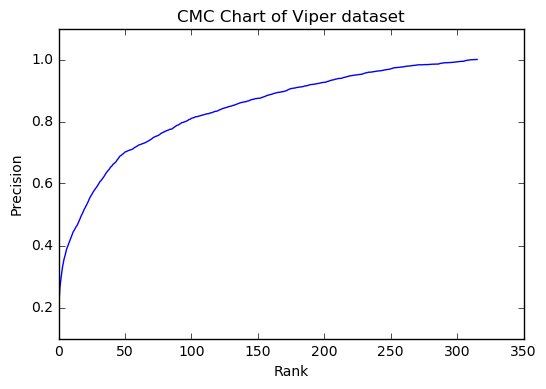

In [26]:
viper = DataWrapper("/root/data/reid/viper/")
#Calculating the average CMC from 10 splits
QX, GX, Q_ID, G_ID = viper.get_split(split=0)
dist_matrix = euclidean_distance(GX, QX)
C = cmc(dist_matrix)
#C = cmc(np.random.rand(row, column))
for split in range(1, 10):
    QX, GX, Q_ID, G_ID = viper.get_split(split=split)
    dist_matrix = euclidean_distance(GX, QX)
    C += cmc(dist_matrix)
C /= 10
#print("Euclidean Distance")
viz_CMC(C)